In [1]:
%matplotlib inline
import os
import datetime
import pickle
import paddle
import paddle.fluid as fluid
import pandas as pd
import numpy as np  
from tqdm import tqdm
from pandas.tseries.frequencies import to_offset
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']

# 随机种子，保证实验能复现
import random
seed = 42
paddle.seed(seed)
np.random.seed(seed)
random.seed(seed)

import warnings
warnings.filterwarnings('ignore')

INPUT_LEN = 120 * 4
OUTPUT_LEN = 24 * 4
STRIDE_LEN = 19 * 4

文件目录：
```
├── data
│   └── data205286
│       └── 功率预测竞赛赛题与数据集.zip
└── 功率预测竞赛赛题与数据集
│   ├── 01.csv
│   ├── 02.csv
    
├── EDA.ipynb                    # EDA
├── main.ipynb                   # 离线训练代码

├── infile                      # 测试预测功能的输入样例数据                
│   ├── 0001in.csv          
│   ├── ... csv
├── pred                       # 测试预测功能的输出样例结果 
│   ├── 0001out.csv
│   ├── ....csv

├── submission                   # 线上提交用的文件
│   ├── env
│   │   ├── data_loader.py        # 数据加载器
│   │   ├── data_preprocess.py     # 数据预处理
│   │   ├── model.py            # 模型结构
│   │   └── utils.py            # 工具函数 
│   ├── model                  # 离线保存的模型文件
│   │   ├── model_checkpoint_windid_1.pdparams 
│   │   ├── ...。pdparams
│   │   └── scaler.pkl
│   ├── pip-requirements.txt        # 依赖库
│   └── predict.py              # 线上预测的py文件
```

# 01 数据预处理和特征工程

这里，以风机04为建模样例。<br>

基于前面的EDA，我们发现数据存在以下问题：
- 原始数据拼接后，时间顺序不一定有序；
- 存在重复值；
- 存在缺失，丢失部分天数或个别天内某些列值会缺失；
- 存在个别离群点。

对此，我们需要进行：
* 读取数据
* 数据排序
* 去除重复值
* 重采样（可选）
* 缺失值处理
* 异常值处理

In [2]:
# 拟合函数
def curfunc(X, a, b, c, d, e, f):
    x, y = X
    return a * x ** 2 + b * x * y + c * y ** 2 + d * x + e * y + f
    '''x = X
    return a * x ** 3 + b * x ** 2 + c * x + d
    '''

def func(df) :
    # 假设func(x,y) = ax^2 + bxy + cy^2 + dx + ey + f
    # 输入一个df，返回拟合好的YD15 = func(WINDSPEED, ROUND(A.WS,0))函数的参数
    # a,b,c,d,e,f
    import numpy as np
    from scipy.optimize import curve_fit
    # 读取数据
    YD15 = df['YD15']
    WINDSPEED = df['WINDSPEED']
    WS_ROUNDED = df['ROUND(A.WS,1)']
    # 拟合
    popt, pcov = curve_fit(curfunc, (WINDSPEED,WS_ROUNDED), YD15) 
    a, b, c, d, e, f = popt
    return a, b, c, d, e, f

import numpy as np
import pandas as pd

def replace_outliers(df, col_x, col_y):
    df_mean = df.groupby(col_x)[col_y].mean().reset_index(name='mean')
    df_std = df.groupby(col_x)[col_y].std().reset_index(name='std')
    
    df_stats = pd.merge(df_mean, df_std, on=col_x)
    df = pd.merge(df, df_stats, on=col_x)
    
    # 将阈值设置为标准差的3倍
    threshold = 1 * df['std']
    print("==========打印阈值==========")
    print(threshold)
    
    # 找出YD15列中的离群点，并将它们替换为该组中的非离群点均值
    df['outlier'] = np.abs(df[col_y] - df['mean']) > threshold
    df.loc[df['outlier'], col_y] = np.nan
    df[col_y].fillna(df.groupby(col_x)[col_y].transform('mean'), inplace=True)
    
    df.drop(['outlier', 'mean', 'std'], axis=1, inplace=True)
    
    return df
    
def replace_low_YD15(df):
    """
    对于每一行而言，如果ROUND(A.WS,1)>9且YD15<100，则将对应的YD15改为全部YD15的均值。
    """
    # 根据条件筛选需要替换的行
    condition = (df['ROUND(A.WS,1)'] > 9) & (df['YD15'] < 100)
    rows_to_replace = df[condition]

    # 计算YD15的均值
    mean_YD15 = (df['YD15'].mean() + df['YD15'].max()) * 0.5

    # 将满足条件的YD15替换为均值
    df.loc[rows_to_replace.index, 'YD15'] = mean_YD15

    return df

def data_preprocess(df):
    """数据预处理：
        1、读取数据
        2、数据排序
        3、去除重复值
        4、重采样（可选）
        5、缺失值处理
        6、异常值处理
    """
    # ===========读取数据===========
    df = df.sort_values(by='DATATIME', ascending=True)
    print('df.shape:', df.shape)
    print(f"Time range from {df['DATATIME'].values[0]} to {df['DATATIME'].values[-1]}")

    # ===========去除重复值===========
    df = df.drop_duplicates(subset='DATATIME', keep='first')
    print('After Dropping dulicates:', df.shape)

    # ===========重采样（可选） + 线性插值===========
    df = df.set_index('DATATIME')
    # 重采样（可选）：比如04风机缺少2022-04-10和2022-07-25两天的数据，重采样会把这两天数据补充进来
    # df = df.resample(rule=to_offset('15T').freqstr, label='right', closed='right').interpolate(method='linear', limit_direction='both').reset_index()
    # TODO 尝试一些其他缺失值处理方式，比如，用同时刻附近风机的值求均值填补缺失值
    df = df.interpolate(method='linear', limit_direction='both').reset_index()
    print('After Resampling:', df.shape)

    # ===========异常值处理===========
    # 当实际风速为0时，功率置为0
    df.loc[df['ROUND(A.WS,1)']==0, 'YD15'] = 0
    df.loc[df['ROUND(A.WS,1)']==0, 'ROUND(A.POWER,0)'] = 0
    
    # ===========新增一些清洗数据的步骤===========
    # 1.对缺失值进行填充：当"ROUND(A.POWER,0)", "YD15"仅一个为空时，以其中一个替代另一个
    df["ROUND(A.POWER,0)"] = df.apply(lambda row: row["YD15"] 
        if pd.isna(row["ROUND(A.POWER,0)"]) and not pd.isna(row["YD15"]) 
        else row["ROUND(A.POWER,0)"], axis=1
    )
    df["YD15"] = df.apply(lambda row: row["ROUND(A.POWER,0)"] 
        if pd.isna(row["YD15"]) and not pd.isna(row["ROUND(A.POWER,0)"]) 
        else row["YD15"], axis=1
    )

    # 1.1 填充风速
    df['ROUND(A.WS,1)'] = df['ROUND(A.WS,1)'].fillna(df['WINDSPEED'])

    # 2.当一个字段为空时，以前一行代替
    df["ROUND(A.WS,1)"] = df["ROUND(A.WS,1)"].fillna(method="ffill")
    col_mean = df["ROUND(A.WS,1)"].mean()
    df["ROUND(A.WS,1)"] = df["ROUND(A.WS,1)"].fillna(col_mean)

    # 3.替换离群点
    df = replace_low_YD15(df)

    # TODO 风速(WINDSPEED)过大但功率(ROUND(A.POWER,0),YD15)为0的异常：
    # 先设计函数拟合出：实际功率=f(风速);
    # 然后代入异常功率的风速获取理想功率，替换原异常功率.
    a, b, c, d, e, f = func(df)
    # 计算WINDSPEED列的平均值
    mean_wind_speed = df['WINDSPEED'].mean()
    mean_round_ws = df['ROUND(A.WS,1)'].mean()
    # 将满足条件的行的YD15值改为拟合的数值
    df.loc[
        (df['WINDSPEED'] > mean_wind_speed) & (df['YD15'] == 0), 'YD15'
    ] = a * df['WINDSPEED']**2 + \
        b * df['WINDSPEED'] * df['ROUND(A.WS,1)'] + \
        c * df['ROUND(A.WS,1)']**2 + d * df['WINDSPEED'] + e * df['ROUND(A.WS,1)'] + f

    # 将满足条件的行的ROUND(A.POWER,0)值改为拟合的数值
    '''df.loc[
        (df['WINDSPEED'] > mean_wind_speed) & (df['ROUND(A.POWER,0)'] == 0), 'ROUND(A.POWER,0)'
    ] = a * df['ROUND(A.WS,1)']**3 + \
        b * df['ROUND(A.WS,1)'] **2 + \
        c * df['ROUND(A.WS,1)'] +\
        d'''
    df.loc[
        (df['WINDSPEED'] > mean_wind_speed) & (df['ROUND(A.POWER,0)'] == 0), 'ROUND(A.POWER,0)'
    ] = a * df['WINDSPEED']**2 + \
        b * df['WINDSPEED'] * df['ROUND(A.WS,1)'] + \
        c * df['ROUND(A.WS,1)']**2 + d * df['WINDSPEED'] + e * df['ROUND(A.WS,1)'] + f

    # TODO 对于在特定风速下的离群功率（同时刻用IQR检测出来），做功率修正（如均值修正）
    df = replace_outliers(df, 'WINDSPEED', 'YD15')
    df = replace_outliers(df, 'WINDSPEED', 'ROUND(A.POWER,0)')
    return df

def feature_engineer(df):
    """特征工程：时间戳特征"""
    # 时间戳特征
    df['month'] = df.DATATIME.apply(lambda row: row.month, 1)
    df['day'] = df.DATATIME.apply(lambda row: row.day, 1)
    df['weekday'] = df.DATATIME.apply(lambda row: row.weekday(), 1)
    df['hour'] = df.DATATIME.apply(lambda row: row.hour, 1)
    df['minute'] = df.DATATIME.apply(lambda row: row.minute, 1)

    # TODO 挖掘更多特征：差分序列、同时刻风场/邻近风机的特征均值/标准差等
    # 1. 同时刻风场1-10 WINDSPEED平均值
    '''
    diff_windspeed = df["WINDSPEED"].diff()
    diff_windspeed.iloc[0] = 0  # 将第一个元素设置为 0
    df["DELTA_WINDSPEED"] = diff_windspeed

    diff_prepower = df["PREPOWER"].diff()
    diff_prepower.iloc[0] = 0  # 将第一个元素设置为 0
    df["DELTA_PREPOWER"] = diff_prepower

    diff_temperature = df["TEMPERATURE"].diff()
    diff_temperature.iloc[0] = 0  # 将第一个元素设置为 0
    df["DELTA_TEMPERATURE"] = diff_temperature

    diff_pressure = df["PRESSURE"].diff()
    diff_pressure.iloc[0] = 0  # 将第一个元素设置为 0
    df["DELTA_PRESSURE"] = diff_pressure
    '''

    diff_ws = df["ROUND(A.WS,1)"].diff()
    diff_ws.iloc[0] = 0  # 将第一个元素设置为 0
    df["DELTA_WS"] = diff_ws
    rol_size = 5  # 滑动窗口大小，根据实际情况调整
    rol_ws = df['ROUND(A.WS,1)'].rolling(window=rol_size).mean()
    std_ws = df['ROUND(A.WS,1)'].rolling(window=rol_size).std()
    for i in range (0, rol_size - 1) :
        rol_ws.iloc[i] = df['ROUND(A.WS,1)'][i]
        std_ws.iloc[i] = 0.9
    df['ROL_WS'] = rol_ws  # 添加新列到原 DataFrame 中
    df["STD_WS"] = std_ws

    return df

# 02 构建建模所需模块

## 2.1. 早停
当验证集超过patience个epoch没有出现更好的评估分数，及早终止训练，避免过拟合训练集，若当前epoch表现超过历史最佳分数，保存该节点模型。<br><br>
![](https://ai-studio-static-online.cdn.bcebos.com/b61f66ab7e58438f99a25ff8245b29a6c53d59f645d44717afcd3dde628d2f75)

In [3]:
class EarlyStopping():
    """早停
    当验证集超过patience个epoch没有出现更好的评估分数，及早终止训练
    若当前epoch表现超过历史最佳分数，保存该节点模型
    参考：https://blog.csdn.net/m0_63642362/article/details/121244655
    """
    def __init__(self, patience=7, verbose=False, delta=0, ckp_save_path='/home/aistudio/submission/model/model_checkpoint_windid_04.pdparams'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.ckp_save_path = ckp_save_path

    def __call__(self, val_loss, model):
        print("val_loss={}".format(val_loss))
        score = -val_loss
        # 首轮，直接更新best_score和保存节点模型
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        # 若当前epoch表现没超过历史最佳分数，且累积发生次数超过patience，早停
        elif score < self.best_score+self.delta:
            self.counter+=1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter>=self.patience:
                self.early_stop = True
        # 若当前epoch表现超过历史最佳分数，更新best_score，保存该节点模型
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        # 保存模型
        if self.verbose:
            print(
                f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        paddle.save(model.state_dict(), self.ckp_save_path)
        self.val_loss_min = val_loss

## 2.2. 数据集划分
以时间序列举例，因为一般测试集也会是未来数据，所以我们也要保证训练集是历史数据，而划分出的验证集是未来数据，不然会发生“时间穿越”的数据泄露问题，导致模型过拟合(例如用未来预测历史数据)，这个时候就有两种验证划分方式可参考使用：
* TimeSeriesSplit：Sklearn提供的TimeSeriesSplit；
* 固定窗口滑动划分法：固定时间窗口，不断在数据集上滑动，获得训练集和验证集。(个人推荐这种)。<br><br>
![](https://ai-studio-static-online.cdn.bcebos.com/1f20ee4343134d61bfe19f2dce071b59feb1e666525b4df0ab809d9ffd35d13a)

在时序任务中，有2类数据源，如下图所示：
（1）静态变量（Static Covariates）：不会随时间变化的变量，例如风机id、风机位置;<br>
（2）时变变量（Time-dependent Inputs）：随时间变化的变量;<br>
* 过去观测的时变变量（Past-observed Inputs）：过去可知，但未来不可知，例如历史风速、温度、气压等
* 先验已知未来的时变变量（Apriori-known Future Inputs）：过去和未来都可知，例如天气预报未来风速、温度、气压等；<br><br>
![](https://ai-studio-static-online.cdn.bcebos.com/cff37027414e41dda23ac98ef30a0ceaa68eca088c804ff889f49a6333ffe75d)<br>
资料来源：[【时序】TFT：Temporal Fusion Transformers](https://mp.weixin.qq.com/s/0AXSOgivCytHKTCmpPJfFg)

In [4]:
# unix时间戳转换
def to_unix_time(dt):
    # timestamp to unix
    epoch = datetime.datetime.utcfromtimestamp(0)
    return int((dt - epoch).total_seconds())

def from_unix_time(unix_time):
    # unix to timestamp
    return datetime.datetime.utcfromtimestamp(unix_time)

class TSDataset(paddle.io.Dataset):
    """时序DataSet
    划分数据集、适配dataloader所需的dataset格式
    ref: https://github.com/thuml/Autoformer/blob/main/data_provider/data_loader.py
    """
    def __init__(self, data, 
                 ts_col='DATATIME',
                 use_cols =['WINDSPEED', 'PREPOWER', 'WINDDIRECTION', 'TEMPERATURE', 'HUMIDITY', 
                            'PRESSURE', 'ROUND(A.WS,1)', 'ROUND(A.POWER,0)', 'YD15',
                            'month', 'day', 'weekday', 'hour', 'minute',
                            'DELTA_WS', 'ROL_WS', 'STD_WS'],
                 labels = ['ROUND(A.POWER,0)', 'YD15'], 
                 input_len = INPUT_LEN, # 24*4*5, 
                 pred_len = OUTPUT_LEN, # 24*4, 
                 stride = STRIDE_LEN, 
                 data_type='train',
                 train_ratio = 0.7, val_ratio = 0.15):
        super(TSDataset, self).__init__()
        self.ts_col = ts_col        # 时间戳列
        self.use_cols = use_cols    # 训练时使用的特征列
        self.labels = labels        # 待预测的标签列
        self.input_len = input_len  # 模型输入数据的样本点长度，15分钟间隔，一个小时14个点，近5天的数据就是24*4*5
        self.pred_len = pred_len    # 预测长度，预测次日00:00至23:45实际功率，即1天：24*4
        self.data_type = data_type  # 需要加载的数据类型
        self.scale = True           # 是否需要标准化
        self.train_ratio = train_ratio # 训练集划分比例
        self.val_ratio = val_ratio  # 验证集划分比例
        # 由于赛题要求利用当日05:00之前的数据，预测次日00:00至23:45实际功率
        # 所以x和label要间隔19*4个点
        self.stride = stride
        assert data_type in ['train', 'val', 'test']    # 确保data_type输入符合要求
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[self.data_type]
          
        self.transform(data)

    def transform(self, df):
        # 获取unix时间戳、输入特征和预测标签
        time_stamps, x_values, y_values = df[self.ts_col].apply(lambda x:to_unix_time(x)).values, df[self.use_cols].values, df[self.labels].values
        # 划分数据集
        # 这里可以按需设置划分比例
        num_train = int(len(df) * self.train_ratio)
        num_vali = int(len(df) * self.val_ratio)
        num_test = len(df) - num_train - num_vali
        border1s = [0, num_train-self.input_len-self.stride, len(df)-num_test-self.input_len-self.stride]
        border2s = [num_train, num_train + num_vali, len(df)]
        # 获取data_type下的左右数据截取边界
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]    

        # 标准化
        self.scaler = StandardScaler()
        if self.scale:
            # 使用训练集得到scaler对象
            train_data = x_values[border1s[0]:border2s[0]]
            self.scaler.fit(train_data)
            data = self.scaler.transform(x_values)
            # 保存scaler
            pickle.dump(self.scaler, open('/home/aistudio/submission/model/scaler.pkl', 'wb'))
        else:
            data = x_values

        # array to paddle tensor
        self.time_stamps = paddle.to_tensor(time_stamps[border1:border2], dtype='int64')
        self.data_x = paddle.to_tensor(data[border1:border2], dtype='float32')
        self.data_y = paddle.to_tensor(y_values[border1:border2], dtype='float32')  

    def __getitem__(self, index):
        """
        实现__getitem__方法，定义指定index时如何获取数据，并返回单条数据（训练数据）
        """
        # 由于赛题要求利用当日05:00之前的数据，预测次日00:00至23:45实际功率
        # 所以x和label要间隔19*4个点
        s_begin = index
        s_end = s_begin + self.input_len
        r_begin = s_end + self.stride
        r_end = r_begin + self.pred_len

        # TODO 可以增加对未来可见数据的获取
        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        ts_x = self.time_stamps[s_begin:s_end]
        ts_y = self.time_stamps[r_begin:r_end]
        return seq_x, seq_y, ts_x, ts_y

    def __len__(self):
        """
        实现__len__方法，返回数据集总数目
        """
        return len(self.data_x) - self.input_len - self.stride - self.pred_len  + 1


class TSPredDataset(paddle.io.Dataset):
    """时序Pred DataSet
    划分数据集、适配dataloader所需的dataset格式
    ref: https://github.com/thuml/Autoformer/blob/main/data_provider/data_loader.py
    """
    def __init__(self, data, 
                 ts_col='DATATIME',
                 use_cols =['WINDSPEED', 'PREPOWER', 'WINDDIRECTION', 'TEMPERATURE', 'HUMIDITY', 
                            'PRESSURE', 'ROUND(A.WS,1)', 'ROUND(A.POWER,0)', 'YD15',
                            'month', 'day', 'weekday', 'hour', 'minute', 
                            'DELTA_WS', 'ROL_WS', 'STD_WS'],
                 labels = ['ROUND(A.POWER,0)', 'YD15'],  
                 input_len = INPUT_LEN, # 24*4*5, 
                 pred_len = OUTPUT_LEN, # 24*4, 
                 stride = STRIDE_LEN):
        super(TSPredDataset, self).__init__()
        self.ts_col = ts_col        # 时间戳列
        self.use_cols = use_cols    # 训练时使用的特征列
        self.labels = labels        # 待预测的标签列
        self.input_len = input_len  # 模型输入数据的样本点长度，15分钟间隔，一个小时14个点，近5天的数据就是24*4*5
        self.pred_len = pred_len    # 预测长度，预测次日00:00至23:45实际功率，即1天：24*4
        # 由于赛题要求利用当日05:00之前的数据，预测次日00:00至23:45实际功率
        # 所以x和label要间隔19*4个点
        self.stride = stride        
        self.scale = True           # 是否需要标准化
       
        self.transform(data)

    def transform(self, df):
        # 获取unix时间戳、输入特征和预测标签
        time_stamps, x_values, y_values = df[self.ts_col].apply(lambda x:to_unix_time(x)).values, df[self.use_cols].values, df[self.labels].values
        # 截取边界
        border1 = len(df) - self.input_len - self.stride - self.pred_len
        border2 = len(df)   

        # 标准化
        self.scaler = StandardScaler()
        if self.scale:
            # 读取预训练好的scaler
            self.scaler = pickle.load(open('/home/aistudio/submission/model/scaler.pkl', 'rb'))
            data = self.scaler.transform(x_values)
        else:
            data = x_values

        # array to paddle tensor
        self.time_stamps = paddle.to_tensor(time_stamps[border1:border2], dtype='int64')
        self.data_x = paddle.to_tensor(data[border1:border2], dtype='float32')
        self.data_y = paddle.to_tensor(y_values[border1:border2], dtype='float32')  

    def __getitem__(self, index):
        """
        实现__getitem__方法，定义指定index时如何获取数据，并返回单条数据（训练数据）
        """
        # 由于赛题要求利用当日05:00之前的数据，预测次日00:00至23:45实际功率
        # 所以x和label要间隔19*4个点
        s_begin = index
        s_end = s_begin + self.input_len
        r_begin = s_end + self.stride
        r_end = r_begin + self.pred_len

        # TODO 可以增加对未来可见数据的获取
        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        ts_x = self.time_stamps[s_begin:s_end]
        ts_y = self.time_stamps[r_begin:r_end]
        return seq_x, seq_y, ts_x, ts_y

    def __len__(self):
        """
        实现__len__方法，返回数据集总数目
        """
        return len(self.data_x) - self.input_len - self.stride - self.pred_len  + 1

## 2.3 模型结构定义
多任务LSTM时序预测模型：LSTM为共享层网络，对两个预测目标分别有两个分支独立线性层网络。<br><br>
![](https://ai-studio-static-online.cdn.bcebos.com/176e23c37f24470e9bf2e6f77a5764bd3c4e2da55f2d4fb8a507abd2c8d06753)


In [5]:
class MultiTaskLSTM(paddle.nn.Layer):
    """多任务LSTM时序预测模型
    LSTM为共享层网络,对两个预测目标分别有两个分支独立线性层网络
    
    TODO 其实该模型就是个Encoder,如果后续要引入天气预测未来的变量,补充个Decoder
    然后Encoder负责历史变量的编码
    Decoder负责将 编码后的历史编码结果 和 它编码未来变量的编码结果 合并后，做解码预测即可
    """
    def __init__(self,
                feat_num=17, hidden_size=64, num_layers=2, 
                dropout_rate=0.1, 
                input_len = INPUT_LEN, # 120*4, 
                pred_len = OUTPUT_LEN ,#24*4
                ):
        super(MultiTaskLSTM, self).__init__()
        # LSTM为共享层网络

        '''
        self.feat_weights = paddle.to_tensor(
            [0.01, 0.75, 0.80, 0.06, 0.25, 0.19, 0.25, 0.95, 0.99, 0.01, 0.01, 0.01, 0.01, 0.01]
        )  # 假设权重分别为1、2、3、4...
        '''

        self.lstm_layer = paddle.nn.LSTM(feat_num, hidden_size, 
                                        num_layers=num_layers, 
                                        direction='forward', 
                                        dropout=dropout_rate)
        # 为'ROUND(A.POWER,0)'构建分支网络
        self.linear1_1 = paddle.nn.Linear(in_features=input_len*hidden_size, out_features=hidden_size*2)
        self.linear1_2 = paddle.nn.Linear(in_features=hidden_size*2, out_features=pred_len)
        # 为'YD15'构建分支网络 
        self.linear2_1 = paddle.nn.Linear(in_features=input_len*hidden_size, out_features=hidden_size*2)
        self.linear2_2 = paddle.nn.Linear(in_features=hidden_size*2, out_features=pred_len)
        self.dropout = paddle.nn.Dropout(dropout_rate)

        
    def forward(self, x):
        # x形状大小为[batch_size, input_len, feature_size]
        # output形状大小为[batch_size, input_len, hidden_size]
        # hidden形状大小为[num_layers, batch_size, hidden_size]
        # print(x)

        # x = paddle.multiply(x, self.feat_weights)

        output, (hidden, cell) = self.lstm_layer(x)
        # output: [batch_size, input_len, hidden_size] -> 
        # [batch_size, input_len*pred_len]
        output = paddle.reshape(output, [len(output), -1])

        output1 = self.linear1_1(output)
        output1 = self.dropout(output1)
        output1 = self.linear1_2(output1)
        # output1 = paddle.nn.functional.relu(output1)

        ## 原来是删除的
        '''output1 = self.dropout(output1)
        output1 = self.linear1_3(output1)
        '''

        output2 = self.linear2_1(output)
        output2 = self.dropout(output2)
        output2 = self.linear2_2(output2)
        # output2 = paddle.nn.functional.relu(output1)

        ## 原来是删除的
        '''output2 = self.dropout(output2)
        output2 = self.linear2_3(output2)
        '''

        # outputs: ([batch_size, pre_len, 1], [batch_size, pre_len, 1])
        return [output1, output2]

Loss用MSE, Metric用官方定义的准确率：<br><br>
![](https://ai-studio-static-online.cdn.bcebos.com/88e6e9b0bb49401db7dfa77992ac84c4399c0225fb4f42f3803238202e5518c0)



In [6]:
class MultiTaskMSELoss(paddle.nn.Layer):
    """
    设置损失函数, 多任务模型，两个任务MSE的均值做loss输出
    """
    def __init__(self):
        super(MultiTaskMSELoss, self).__init__()

    def forward(self, inputs, labels):
        mse_loss = paddle.nn.loss.MSELoss()
        mse1 = mse_loss(inputs[0], labels[:,:,0].squeeze(-1))
        mse2 = mse_loss(inputs[1], labels[:,:,1].squeeze(-1))
        # TODO 也可以自行设置各任务的权重，让其更偏好YD15
        # 即让多任务有主次之分
        return mse1, mse2, (mse1 + mse2) / 2
        # return mse1, mse2, 0.4*mse1+0.6*mse2

def calc_acc(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    return 1 - rmse/201000

# 03 模型训练\验证\测试

In [7]:
def train(df, turbine_id):
    # 设置数据集
    train_dataset = TSDataset(df, input_len = input_len, pred_len = pred_len, data_type='train')
    val_dataset = TSDataset(df, input_len = input_len, pred_len = pred_len, data_type='val')
    test_dataset = TSDataset(df, input_len = input_len, pred_len = pred_len, data_type='test')
    print(f'LEN | train_dataset:{len(train_dataset)}, val_dataset:{len(val_dataset)}, test_dataset:{len(test_dataset)}')

    # 设置数据读取器
    train_loader = paddle.io.DataLoader(train_dataset, shuffle=True, batch_size=batch_size, drop_last=True)
    val_loader = paddle.io.DataLoader(val_dataset, shuffle=False, batch_size=batch_size, drop_last=True)
    test_loader = paddle.io.DataLoader(test_dataset, shuffle=False, batch_size=1, drop_last=False)

    # 设置模型
    model = MultiTaskLSTM()

    # 设置优化器
    scheduler = paddle.optimizer.lr.ReduceOnPlateau(learning_rate=learning_rate, factor=0.5, patience=3, verbose=True)
    opt = paddle.optimizer.Adam(learning_rate=scheduler, parameters=model.parameters())

    # 设置损失
    mse_loss = MultiTaskMSELoss()
    #mse_loss = MultiTaskMAELoss()

    train_loss = []
    valid_loss = []
    train_epochs_loss = []
    valid_epochs_loss = []
    early_stopping = EarlyStopping(patience=patience, verbose=True, ckp_save_path=f'/home/aistudio/submission/model/model_checkpoint_windid_{turbine_id}.pdparams')

    for epoch in tqdm(range(epoch_num)):
        # =====================train============================
        train_epoch_loss, train_epoch_mse1,  train_epoch_mse2 = [], [], []
        model.train() # 开启训练
        for batch_id, data in enumerate(train_loader()):             
            x = data[0]
            y = data[1]
            # 预测
            outputs = model(x)
            # 计算损失
            mse1, mse2, avg_loss = mse_loss(outputs, y)
            # 反向传播
            avg_loss.backward()
            # 梯度下降
            opt.step()
            # 清空梯度
            opt.clear_grad()
            train_epoch_loss.append(avg_loss.numpy()[0])
            train_loss.append(avg_loss.item())
            train_epoch_mse1.append(mse1.item())
            train_epoch_mse2.append(mse2.item())
        train_epochs_loss.append(np.average(train_epoch_loss))
        print("epoch={}/{} of train | loss={}, MSE of ROUND(A.POWER,0):{}, MSE of YD15:{} ".format(epoch, epoch_num,
        np.average(train_epoch_loss), np.average(train_epoch_mse1), np.average(train_epoch_mse2)))

        # =====================valid============================
        model.eval() # 开启评估/预测
        valid_epoch_loss, valid_epochs_mse1,  valid_epochs_mse2 = [], [], []
        for batch_id, data in enumerate(val_loader()): 
            x = data[0]
            y = data[1]
            outputs = model(x)
            mse1, mse2, avg_loss = mse_loss(outputs, y)
            valid_epoch_loss.append(avg_loss.numpy()[0])
            valid_loss.append(avg_loss.numpy()[0])
            valid_epochs_mse1.append(mse1.item())
            valid_epochs_mse2.append(mse2.item())
        valid_epochs_loss.append(np.average(valid_epoch_loss))
        print('Valid: MSE of ROUND(A.POWER,0):{}, MSE of YD15:{}'.format(np.average(train_epoch_mse1), np.average(train_epoch_mse2)))
        
        # ==================early stopping======================
        early_stopping(valid_epochs_loss[-1], model=model)
        if early_stopping.early_stop:
            print(f"Early stopping at Epoch {epoch-patience}")
            break

    print('Train & Valid: ')
    plt.figure(figsize=(12,3))
    plt.subplot(121)
    plt.plot(train_loss[:],label="train")
    plt.title("train_loss")
    plt.xlabel('iteration')
    plt.subplot(122)
    plt.plot(train_epochs_loss[1:],'-o',label="train")
    plt.plot(valid_epochs_loss[1:],'-o',label="valid")
    plt.title("epochs_loss")
    plt.xlabel('epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # =====================test============================
    # 加载最优epoch节点下的模型
    model = MultiTaskLSTM()
    model.set_state_dict(paddle.load(f'/home/aistudio/submission/model/model_checkpoint_windid_{turbine_id}.pdparams'))

    model.eval() # 开启评估/预测
    test_loss, test_epoch_mse1, test_epoch_mse2 = [], [], []
    test_accs1, test_accs2 = [], [] 
    for batch_id, data in tqdm(enumerate(test_loader())): 
        x = data[0]
        y = data[1]
        ts_y = [from_unix_time(x) for x in data[3].numpy().squeeze(0)]
        outputs = model(x)
        mse1, mse2, avg_loss = mse_loss(outputs, y)
        acc1 = calc_acc(y.numpy().squeeze(0)[:,0], outputs[0].numpy().squeeze(0))
        acc2 = calc_acc(y.numpy().squeeze(0)[:,1], outputs[1].numpy().squeeze(0))
        test_loss.append(avg_loss.numpy()[0])
        test_epoch_mse1.append(mse1.numpy()[0])
        test_epoch_mse2.append(mse2.numpy()[0])
        test_accs1.append(acc1)
        test_accs2.append(acc2)

    print('Test: ')
    print('MSE of ROUND(A.POWER,0):{}, MSE of YD15:{}'.format(np.average(test_epoch_mse1), np.average(test_epoch_mse2)))
    print('Mean MSE:', np.mean(test_loss))
    print('ACC of ROUND(A.POWER,0):{}, ACC of YD15:{}'.format(np.average(test_accs1), np.average(test_accs2)))

==============现在训练的是：TURBIN  12.csv ==============
turbine_id:12
df.shape: (19200, 10)
Time range from 2021-12-12T09:15:00.000000000 to 2022-06-30T23:45:00.000000000
After Dropping dulicates: (19163, 10)
After Resampling: (19163, 10)
==========打印阈值==========
0        38019.368060
1        38019.368060
2        38019.368060
3        38019.368060
4        38019.368060
             ...     
19158             NaN
19159    35738.699533
19160    35738.699533
19161    35738.699533
19162             NaN
Name: std, Length: 19163, dtype: float64
==========打印阈值==========
0        36874.336279
1        36874.336279
2        36874.336279
3        36874.336279
4        36874.336279
             ...     
19158             NaN
19159    33511.975178
19160    33511.975178
19161    33511.975178
19162             NaN
Name: std, Length: 19163, dtype: float64
==========以下是本数据集的信息==========
<class 'pandas.core.frame.DataFrame'>
Int64Index: 19163 entries, 0 to 19162
Data columns (total 18 columns):
 #   Colum

  0%|          | 0/30 [00:00<?, ?it/s]

epoch=0/30 of train | loss=909713984.0, MSE of ROUND(A.POWER,0):949549198.3673469, MSE of YD15:869878735.6734694 


  3%|▎         | 1/30 [00:03<01:36,  3.33s/it]

Valid: MSE of ROUND(A.POWER,0):949549198.3673469, MSE of YD15:869878735.6734694
val_loss=664983808.0
Validation loss decreased (inf --> 664983808.000000).  Saving model ...
epoch=1/30 of train | loss=463256320.0, MSE of ROUND(A.POWER,0):465277123.9183673, MSE of YD15:461235402.4489796 
Valid: MSE of ROUND(A.POWER,0):465277123.9183673, MSE of YD15:461235402.4489796
val_loss=508822880.0
Validation loss decreased (664983808.000000 --> 508822880.000000).  Saving model ...


  7%|▋         | 2/30 [00:07<01:38,  3.53s/it]

epoch=2/30 of train | loss=305213408.0, MSE of ROUND(A.POWER,0):304347391.67346936, MSE of YD15:306079443.59183675 


 10%|█         | 3/30 [00:10<01:33,  3.48s/it]

Valid: MSE of ROUND(A.POWER,0):304347391.67346936, MSE of YD15:306079443.59183675
val_loss=414328000.0
Validation loss decreased (508822880.000000 --> 414328000.000000).  Saving model ...
epoch=3/30 of train | loss=237706448.0, MSE of ROUND(A.POWER,0):237563734.85714287, MSE of YD15:237849193.14285713 


 13%|█▎        | 4/30 [00:13<01:29,  3.44s/it]

Valid: MSE of ROUND(A.POWER,0):237563734.85714287, MSE of YD15:237849193.14285713
val_loss=314165696.0
Validation loss decreased (414328000.000000 --> 314165696.000000).  Saving model ...
epoch=4/30 of train | loss=188143664.0, MSE of ROUND(A.POWER,0):190320751.3469388, MSE of YD15:185966581.5510204 


 17%|█▋        | 5/30 [00:17<01:27,  3.49s/it]

Valid: MSE of ROUND(A.POWER,0):190320751.3469388, MSE of YD15:185966581.5510204
val_loss=285269728.0
Validation loss decreased (314165696.000000 --> 285269728.000000).  Saving model ...
epoch=5/30 of train | loss=171984192.0, MSE of ROUND(A.POWER,0):174833936.6530612, MSE of YD15:169134414.69387755 


 20%|██        | 6/30 [00:20<01:22,  3.44s/it]

Valid: MSE of ROUND(A.POWER,0):174833936.6530612, MSE of YD15:169134414.69387755
val_loss=297540096.0
EarlyStopping counter: 1 out of 15
epoch=6/30 of train | loss=167963776.0, MSE of ROUND(A.POWER,0):171050706.2857143, MSE of YD15:164876869.5510204 


 23%|██▎       | 7/30 [00:24<01:18,  3.43s/it]

Valid: MSE of ROUND(A.POWER,0):171050706.2857143, MSE of YD15:164876869.5510204
val_loss=275657344.0
Validation loss decreased (285269728.000000 --> 275657344.000000).  Saving model ...
epoch=7/30 of train | loss=159792512.0, MSE of ROUND(A.POWER,0):163039794.9387755, MSE of YD15:156545238.20408162 


 27%|██▋       | 8/30 [00:27<01:15,  3.41s/it]

Valid: MSE of ROUND(A.POWER,0):163039794.9387755, MSE of YD15:156545238.20408162
val_loss=363296384.0
EarlyStopping counter: 1 out of 15
epoch=8/30 of train | loss=154624432.0, MSE of ROUND(A.POWER,0):157632908.08163264, MSE of YD15:151615986.2857143 


 30%|███       | 9/30 [00:30<01:10,  3.38s/it]

Valid: MSE of ROUND(A.POWER,0):157632908.08163264, MSE of YD15:151615986.2857143
val_loss=283357152.0
EarlyStopping counter: 2 out of 15
epoch=9/30 of train | loss=151993360.0, MSE of ROUND(A.POWER,0):155021307.75510204, MSE of YD15:148965401.46938777 


 33%|███▎      | 10/30 [00:34<01:06,  3.34s/it]

Valid: MSE of ROUND(A.POWER,0):155021307.75510204, MSE of YD15:148965401.46938777
val_loss=292290688.0
EarlyStopping counter: 3 out of 15
epoch=10/30 of train | loss=150341200.0, MSE of ROUND(A.POWER,0):153224905.14285713, MSE of YD15:147457486.36734694 


 37%|███▋      | 11/30 [00:37<01:03,  3.32s/it]

Valid: MSE of ROUND(A.POWER,0):153224905.14285713, MSE of YD15:147457486.36734694
val_loss=312047840.0
EarlyStopping counter: 4 out of 15
epoch=11/30 of train | loss=149801120.0, MSE of ROUND(A.POWER,0):152724511.3469388, MSE of YD15:146877728.3265306 


 40%|████      | 12/30 [00:40<00:59,  3.31s/it]

Valid: MSE of ROUND(A.POWER,0):152724511.3469388, MSE of YD15:146877728.3265306
val_loss=308504512.0
EarlyStopping counter: 5 out of 15
epoch=12/30 of train | loss=151241104.0, MSE of ROUND(A.POWER,0):153877497.79591838, MSE of YD15:148604701.7142857 


 43%|████▎     | 13/30 [00:44<00:56,  3.33s/it]

Valid: MSE of ROUND(A.POWER,0):153877497.79591838, MSE of YD15:148604701.7142857
val_loss=305636320.0
EarlyStopping counter: 6 out of 15
epoch=13/30 of train | loss=149414592.0, MSE of ROUND(A.POWER,0):152136003.59183672, MSE of YD15:146693212.73469388 


 47%|████▋     | 14/30 [00:47<00:53,  3.33s/it]

Valid: MSE of ROUND(A.POWER,0):152136003.59183672, MSE of YD15:146693212.73469388
val_loss=300312032.0
EarlyStopping counter: 7 out of 15
epoch=14/30 of train | loss=148483472.0, MSE of ROUND(A.POWER,0):151244166.53061223, MSE of YD15:145722788.89795917 


 50%|█████     | 15/30 [00:50<00:49,  3.32s/it]

Valid: MSE of ROUND(A.POWER,0):151244166.53061223, MSE of YD15:145722788.89795917
val_loss=287165888.0
EarlyStopping counter: 8 out of 15
epoch=15/30 of train | loss=148057504.0, MSE of ROUND(A.POWER,0):150841924.24489796, MSE of YD15:145273104.6530612 


 53%|█████▎    | 16/30 [00:54<00:46,  3.34s/it]

Valid: MSE of ROUND(A.POWER,0):150841924.24489796, MSE of YD15:145273104.6530612
val_loss=302831904.0
EarlyStopping counter: 9 out of 15
epoch=16/30 of train | loss=147832240.0, MSE of ROUND(A.POWER,0):150700647.83673468, MSE of YD15:144963840.81632653 


 57%|█████▋    | 17/30 [00:57<00:42,  3.30s/it]

Valid: MSE of ROUND(A.POWER,0):150700647.83673468, MSE of YD15:144963840.81632653
val_loss=312624672.0
EarlyStopping counter: 10 out of 15
epoch=17/30 of train | loss=156310096.0, MSE of ROUND(A.POWER,0):159167367.18367347, MSE of YD15:153452813.7142857 
Valid: MSE of ROUND(A.POWER,0):159167367.18367347, MSE of YD15:153452813.7142857
val_loss=274204224.0
Validation loss decreased (275657344.000000 --> 274204224.000000).  Saving model ...


 60%|██████    | 18/30 [01:00<00:40,  3.37s/it]

epoch=18/30 of train | loss=152954832.0, MSE of ROUND(A.POWER,0):155741258.12244898, MSE of YD15:150168418.7755102 


 63%|██████▎   | 19/30 [01:04<00:36,  3.36s/it]

Valid: MSE of ROUND(A.POWER,0):155741258.12244898, MSE of YD15:150168418.7755102
val_loss=284167264.0
EarlyStopping counter: 1 out of 15
epoch=19/30 of train | loss=148824896.0, MSE of ROUND(A.POWER,0):151674654.36734694, MSE of YD15:145975130.12244898 


 67%|██████▋   | 20/30 [01:07<00:33,  3.35s/it]

Valid: MSE of ROUND(A.POWER,0):151674654.36734694, MSE of YD15:145975130.12244898
val_loss=295724096.0
EarlyStopping counter: 2 out of 15
epoch=20/30 of train | loss=149792976.0, MSE of ROUND(A.POWER,0):152712181.87755102, MSE of YD15:146873779.91836736 


 70%|███████   | 21/30 [01:10<00:30,  3.34s/it]

Valid: MSE of ROUND(A.POWER,0):152712181.87755102, MSE of YD15:146873779.91836736
val_loss=304206752.0
EarlyStopping counter: 3 out of 15
epoch=21/30 of train | loss=154550096.0, MSE of ROUND(A.POWER,0):156857671.18367347, MSE of YD15:152242527.02040815 


 73%|███████▎  | 22/30 [01:14<00:26,  3.33s/it]

Valid: MSE of ROUND(A.POWER,0):156857671.18367347, MSE of YD15:152242527.02040815
val_loss=282122240.0
EarlyStopping counter: 4 out of 15
epoch=22/30 of train | loss=149318240.0, MSE of ROUND(A.POWER,0):152344771.26530612, MSE of YD15:146291698.7755102 


 77%|███████▋  | 23/30 [01:17<00:23,  3.34s/it]

Valid: MSE of ROUND(A.POWER,0):152344771.26530612, MSE of YD15:146291698.7755102
val_loss=278623168.0
EarlyStopping counter: 5 out of 15
epoch=23/30 of train | loss=148305536.0, MSE of ROUND(A.POWER,0):151275681.63265306, MSE of YD15:145335389.87755102 


 80%|████████  | 24/30 [01:20<00:20,  3.35s/it]

Valid: MSE of ROUND(A.POWER,0):151275681.63265306, MSE of YD15:145335389.87755102
val_loss=280606272.0
EarlyStopping counter: 6 out of 15
epoch=24/30 of train | loss=147381712.0, MSE of ROUND(A.POWER,0):150410170.4489796, MSE of YD15:144353271.3469388 


 83%|████████▎ | 25/30 [01:24<00:16,  3.34s/it]

Valid: MSE of ROUND(A.POWER,0):150410170.4489796, MSE of YD15:144353271.3469388
val_loss=280757728.0
EarlyStopping counter: 7 out of 15
epoch=25/30 of train | loss=151833856.0, MSE of ROUND(A.POWER,0):154848671.3469388, MSE of YD15:148819054.04081634 


 87%|████████▋ | 26/30 [01:27<00:13,  3.33s/it]

Valid: MSE of ROUND(A.POWER,0):154848671.3469388, MSE of YD15:148819054.04081634
val_loss=277343616.0
EarlyStopping counter: 8 out of 15
epoch=26/30 of train | loss=150621488.0, MSE of ROUND(A.POWER,0):153527962.7755102, MSE of YD15:147715016.48979592 


 90%|█████████ | 27/30 [01:30<00:10,  3.33s/it]

Valid: MSE of ROUND(A.POWER,0):153527962.7755102, MSE of YD15:147715016.48979592
val_loss=282982880.0
EarlyStopping counter: 9 out of 15
epoch=27/30 of train | loss=147756576.0, MSE of ROUND(A.POWER,0):150936414.36734694, MSE of YD15:144576721.14285713 


 93%|█████████▎| 28/30 [01:34<00:06,  3.36s/it]

Valid: MSE of ROUND(A.POWER,0):150936414.36734694, MSE of YD15:144576721.14285713
val_loss=284077280.0
EarlyStopping counter: 10 out of 15
epoch=28/30 of train | loss=147303488.0, MSE of ROUND(A.POWER,0):150387295.3469388, MSE of YD15:144219662.20408162 


 97%|█████████▋| 29/30 [01:37<00:03,  3.34s/it]

Valid: MSE of ROUND(A.POWER,0):150387295.3469388, MSE of YD15:144219662.20408162
val_loss=292476608.0
EarlyStopping counter: 11 out of 15
epoch=29/30 of train | loss=146991760.0, MSE of ROUND(A.POWER,0):150125015.83673468, MSE of YD15:143858513.63265306 


100%|██████████| 30/30 [01:40<00:00,  3.36s/it]

Valid: MSE of ROUND(A.POWER,0):150125015.83673468, MSE of YD15:143858513.63265306
val_loss=288800128.0
EarlyStopping counter: 12 out of 15
Train & Valid: 


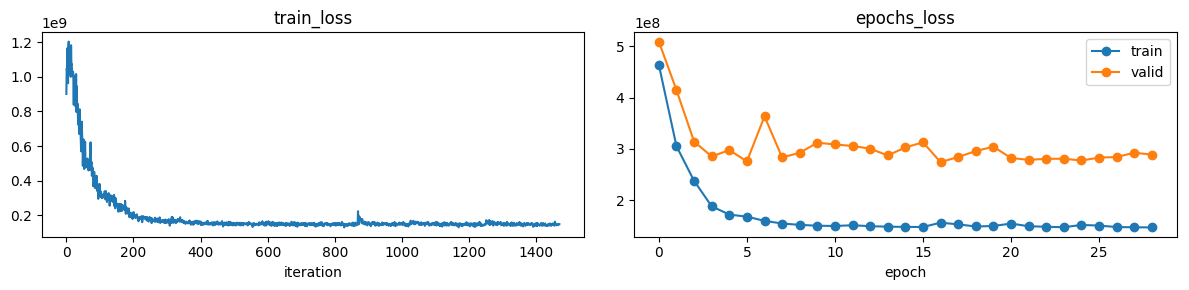

2780it [00:31, 88.31it/s]

Test: 
MSE of ROUND(A.POWER,0):1727368704.0, MSE of YD15:1757988608.0
Mean MSE: 1742678700.0
ACC of ROUND(A.POWER,0):0.8155617157151728, ACC of YD15:0.815330149162503
==============测试完毕：TURBIN  12.csv ==============


In [14]:
data_path = '/home/aistudio/功率预测竞赛赛题与数据集'
files = os.listdir(data_path)
debug = True # 为了快速跑通代码，可以先尝试用采样数据做debug

# 遍历每个风机的数据做训练、验证和测试
for f in files:
    if f!="12.csv": continue    # 方便起见，只训练1个风机
    print("==============现在训练的是：TURBIN ", f,"==============")
    df = pd.read_csv(os.path.join(data_path, f),
                    parse_dates=['DATATIME'],
                    infer_datetime_format=True,
                    dayfirst=True)
    turbine_id = int(float(f.split('.csv')[0]))
    print(f'turbine_id:{turbine_id}')

    if debug:
        df = df.iloc[-24*4*200:,:]

    # 数据预处理
    df = data_preprocess(df)
    # 特征工程
    df = feature_engineer(df)
    print("==========以下是本数据集的信息==========")
    df.info()
    '''
    print("==========以下是本数据集的内容==========")
    print(df.head(100))
    '''

    # 模型参数
    input_len = INPUT_LEN       # 输入序列的长度为 120*4
    # input_len = (24 + 19) * 7 * 4
    pred_len = OUTPUT_LEN       #  预测序列的长度为 24*4
    # pred_len = (24 + 19) * 4
    epoch_num = 30              #  模型训练的轮数，100
    batch_size = 256            # 每个训练批次使用的样本数量，512
    learning_rate = 0.001       # 学习率
    patience = 15               # 如果连续patience个轮次性能没有提升，就会停止训练，10

    # 训练模型
    train(df, turbine_id)
    print("==============测试完毕：TURBIN ", f,"==============")


# 04 预测

In [9]:
'''
def forecast(df, turbine_id, out_file):
    # 数据预处理
    df = data_preprocess(df)
    # 特征工程
    df = feature_engineer(df)
    # 准备数据加载器
    input_len = 120*4
    pred_len = 24*4
    pred_dataset = TSPredDataset(df, input_len = input_len, pred_len = pred_len)
    pred_loader = paddle.io.DataLoader(pred_dataset, shuffle=False, batch_size=1, drop_last=False)
    # 定义模型
    model = MultiTaskLSTM()
    # 导入模型权重文件
    model.set_state_dict(paddle.load(f'submission/model/model_checkpoint_windid_{turbine_id}.pdparams'))
    model.eval() # 开启预测
    for batch_id, data in enumerate(pred_loader()):
        print(data)
        x = data[0]
        y = data[1]
        outputs = model(x)    
        ts_x = [from_unix_time(x) for x in data[2].numpy().squeeze(0)]
        ts_y = [from_unix_time(x) for x in data[3].numpy().squeeze(0)]

    ###### 下面为了测试预测的效果，把输出加上了实际风速

    # result = pd.DataFrame({'DATATIME':ts_y, 'ROUND(A.POWER,0)':outputs[0].squeeze(), 'YD15':outputs[1].squeeze()})
    result = pd.DataFrame({'DATATIME':ts_y, 'ROUND(A.POWER,0)':outputs[0].squeeze(), 'YD15':outputs[1].squeeze()})

    result['TurbID'] = turbine_id
    result['ROUND(A.WS,1)'] = df['ROUND(A.WS,1)']

    result = result[['TurbID', 'DATATIME', 'ROUND(A.WS,1)', 'ROUND(A.POWER,0)', 'YD15']]
    result.to_csv(out_file, index=False)
    '''

def forecast(df, turbine_id, out_file):
    # 数据预处理
    df = data_preprocess(df)
    # 特征工程
    df = feature_engineer(df)
    # 准备数据加载器
    input_len = INPUT_LEN # 120*4
    pred_len = OUTPUT_LEN # 24*4
    pred_dataset = TSPredDataset(df, input_len = input_len, pred_len = pred_len)
    pred_loader = paddle.io.DataLoader(pred_dataset, shuffle=False, batch_size=1, drop_last=False)
    # 定义模型
    model = MultiTaskLSTM()
    # 导入模型权重文件
    model.set_state_dict(paddle.load(f'submission/model/model_checkpoint_windid_{turbine_id}.pdparams'))


    model.eval() # 开启预测
    for batch_id, data in enumerate(pred_loader()):
        x = data[0]
        y = data[1]
        outputs = model(x)    
        apower = [x for x in outputs[0].numpy().squeeze()]
        yd15 = [x for x in outputs[1].numpy().squeeze()]
        ts_x = [from_unix_time(x) for x in data[2].numpy().squeeze(0)]
        ts_y = [from_unix_time(x) for x in data[3].numpy().squeeze(0)]

    result = pd.DataFrame({'DATATIME':ts_y, 'ROUND(A.POWER,0)':apower, 'YD15':yd15})
    result['TurbID'] = turbine_id
    result = result[['TurbID', 'DATATIME', 'ROUND(A.POWER,0)', 'YD15']]

    ## 预测完后再清理一遍
    result['YD15'] = result['YD15'].fillna(df['ROUND(A.POWER,0)'])

    result.loc[result['YD15'] < 0, 'YD15'] = 0
    yd15_mean = df["YD15"].mean()
    result.loc[result['YD15'] == 0, 'YD15'] = yd15_mean

    ###### 回归解法如下 
    '''
    # 首先，在result里面新增一列风速
    df1 =     df[['DATATIME', 'ROUND(A.WS,1)'         ]]
    df2 = result[['TurbID',   'DATATIME',       'YD15']]
    df3 = pd.merge(df1, df2, on='DATATIME', how='inner')
    df3 = df3.dropna()

    # 然后，把YD15改为拟合值
    from scipy.optimize import curve_fit
    import numpy as np
    def func(x, a, b, c, d):
        return a * np.arctan(b * x + c) + d

    x = df['ROUND(A.WS,1)']                            # 提取x和y的值
    y = df['YD15']
    params, _ = curve_fit(func, x, y, maxfev = 100000)  # 进行拟合，maxfev为迭代次数
    a, b, c, d = params                                 # 分离参数

    ## 测试
    import numpy as np
    import matplotlib.pyplot as plt

    # 生成 x 值的范围
    x = np.linspace(0, 15, 100)

    # 计算相应的 y 值
    y = func(x, a, b, c, d)

    # 绘制曲线
    plt.plot(x, y)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Graph of func(x)')
    plt.grid(True)
    plt.show()

    for index, row in df3.iterrows():                   # 用回归值替代异常值
        x = row['ROUND(A.WS,1)']
        df3.at[index, 'YD15'] = func(x, a, b, c, d)
    result = df3[['TurbID', 'DATATIME', 'YD15']]
    '''

    result.to_csv(out_file, index=False)

In [10]:
files = os.listdir('infile')
if not os.path.exists('pred'):
    os.mkdir('pred')
# 第一步，完成数据格式统一
for f in files:
    if '.csv' not in f:
        continue
    print(f)
    # 获取文件路径
    data_file = os.path.join('infile', f)
    print(data_file)
    out_file = os.path.join('pred', f[:4] + 'out.csv')
    df = pd.read_csv(data_file,
                    parse_dates=['DATATIME'],
                    infer_datetime_format=True,
                    dayfirst=True)
    turbine_id = df.TurbID[0]
    # 预测结果
    forecast(df, turbine_id, out_file)

0004in.csv
infile/0004in.csv
df.shape: (3072, 11)
Time range from 2020-01-21T00:00:00.000000000 to 2020-02-21T23:45:00.000000000
After Dropping dulicates: (3072, 11)
After Resampling: (3072, 11)
==========打印阈值==========
0       12574.388905
1       12574.388905
2       12574.388905
3       12574.388905
4       12574.388905
            ...     
3067     1808.984268
3068     1808.984268
3069     1808.984268
3070        0.000000
3071        0.000000
Name: std, Length: 3072, dtype: float64
==========打印阈值==========
0       12756.345599
1       12756.345599
2       12756.345599
3       12756.345599
4       12756.345599
            ...     
3067     1237.785813
3068     1237.785813
3069     1237.785813
3070        0.000000
3071        0.000000
Name: std, Length: 3072, dtype: float64
0006in.csv
infile/0006in.csv
df.shape: (3072, 11)
Time range from 2020-01-21T00:00:00.000000000 to 2020-02-21T23:45:00.000000000
After Dropping dulicates: (3072, 11)
After Resampling: (3072, 11)
==========打印阈值====

In [11]:
# print(df.head(df.size))